In [1]:
import pandas as pd
import numpy as np
import pickle
import gc
from pathlib import Path
import tensorflow as tf

%load_ext autoreload
%autoreload 2
from base import datahandler, prediction_models, evaluation, utils, localizer


2024-02-27 17:45:03.415420: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 17:45:03.415483: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 17:45:03.416265: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-27 17:45:03.422625: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-27 17:45:04.270517: W tensorflow/compiler/tf2

In [2]:
class ClearMemoryCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()

In [3]:
# Define the directory paths
challenge_data_dir = Path('dataset/phase_1_v2/')
data_dir = challenge_data_dir / "train"
labels_dir = challenge_data_dir / 'train_labels.csv'

split_dataframes = datahandler.load_and_prepare_dataframes(data_dir, labels_dir, dtype=np.float32)

#some_dataframes = {df_k : split_dataframes[df_k] for df_k in list(split_dataframes.keys())[:900]}

In [4]:
input_features = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)', 'X (m)', 'Y (m)', 'Z (m)',
       'Vx (m/s)', 'Vy (m/s)', 'Vz (m/s)']


utils.set_random_seed(42)
# ds_gen_ew = datahandler.DatasetGenerator(split_df=split_dataframes,
#                                          exclude_objects=[],
#                                       non_transform_features=['Eccentricity',
#                                                               'Semimajor Axis (m)',
#                                                               'Inclination (deg)',
#                                                               'RAAN (deg)',
#                                                               'Argument of Periapsis (deg)',
#                                                               #'True Anomaly (deg)',
#                                                               #'Longitude (deg)',
#                                                               'Latitude (deg)'],
#                                       diff_transform_features=[#'Eccentricity',
#                                                               #'Semimajor Axis (m)',
#                                                               #'Inclination (deg)',
#                                                               'RAAN (deg)',
#                                                               'Argument of Periapsis (deg)',
#                                                               'True Anomaly (deg)',
#                                                               'Longitude (deg)',
#                                                               'Latitude (deg)'],
#                                       sin_transform_features=[],
#                                       sin_cos_transform_features=[],
#                                       overview_features_mean=[],
#                                       overview_features_std=[],
#                                       add_daytime_feature=False,
#                                       add_yeartime_feature=False,
#                                       add_linear_timeindex=False,
#                                       with_labels=True,
#                                       pad_location_labels=0,
#                                       nonbinary_padding=[110.0, 70.0, 49.0, 34.0, 24.0, 12.0],
#                                       train_val_split=0.8,
#                                       input_stride=2,
#                                       padding='none',
#                                       scale=True,
#                                       unify_value_ranges=True,
#                                       per_object_scaling=False,
#                                       node_class_multipliers={'ID':1.0,'IK':1.0,'AD':1.0,'SS':1.0},
#                                       input_history_steps=48,
#                                       input_future_steps=48,
#                                       seed=181,
#                                       deepcopy=True,
#                                       input_dtype=np.float32,
#                                       sort_inputs=True,
#                                       verbose=2)

ds_gen_ns = datahandler.DatasetGenerator(split_df=split_dataframes,
                                      exclude_objects=[1012, 1383, 1385, 1386, 1471, 1473, 1474],
                                      non_transform_features=['Eccentricity',
                                                              'Semimajor Axis (m)',
                                                              'Inclination (deg)',
                                                              'RAAN (deg)',
                                                              'Argument of Periapsis (deg)',
                                                              #'True Anomaly (deg)',
                                                              #'Longitude (deg)',
                                                              'Latitude (deg)'],
                                      diff_transform_features=[#'Eccentricity',
                                                              #'Semimajor Axis (m)',
                                                              #'Inclination (deg)',
                                                              'RAAN (deg)',
                                                              'Argument of Periapsis (deg)',
                                                              'True Anomaly (deg)',
                                                              'Longitude (deg)',
                                                              'Latitude (deg)'
                                                              ],
                                      sin_transform_features=[#'Eccentricity',
                                                              #'Semimajor Axis (m)',
                                                              #'Inclination (deg)',
                                                              #'RAAN (deg)',
                                                              #'Argument of Periapsis (deg)',
                                                              #'True Anomaly (deg)',
                                                              #'Longitude (deg)',
                                                              #'Latitude (deg)'
                                                              ],
                                      sin_cos_transform_features=[],
                                      overview_features_mean=[#'Longitude (sin)',
                                                              #'RAAN (deg)'
                                                               ],
                                      overview_features_std=[#'Latitude (deg)'
                                                             ],
                                      add_daytime_feature=False,
                                      add_yeartime_feature=False,
                                      add_linear_timeindex=False,
                                      with_labels=True,
                                      pad_location_labels=0,
                                      nonbinary_padding=[110.0, 70.0, 49.0, 34.0, 24.0, 12.0],
                                      train_val_split=0.8,
                                      input_stride=4,
                                      padding='zero', #!
                                      scale=True,
                                      unify_value_ranges=True,
                                      per_object_scaling=False,
                                      node_class_multipliers={'ID':1.0,'IK':0.0,'AD':0.0,'SS':0.0},
                                      input_history_steps=256,
                                      input_future_steps=256,
                                      seed=181,
                                      deepcopy=True,
                                      input_dtype=np.float32,
                                      sort_inputs=True,
                                      verbose=2)

=========================Creating Generator=======================
Seed: 181
nTrain: 1520 nVal: 380 (0.80)
Padding: zero
Horizons: 256-256 @ stride 4
Scaling: True  
Node Class Multipliers: {'ID': 1.0, 'IK': 0.0, 'AD': 0.0, 'SS': 0.0}
Limiting True Anomaly to [0.0, 360.0] and Longitude to [-180.0, 180.0]
Diff Transforming features: ['RAAN (deg)', 'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Longitude (deg)', 'Latitude (deg)']
Wraparound offset for ft RAAN (deg): [180, -180]
Wraparound offset for ft Argument of Periapsis (deg): [180, -180]
Wraparound offset for ft True Anomaly (deg): [270, -90]
Wraparound offset for ft Longitude (deg): [180, -180]
Wraparound offset for ft Latitude (deg): []
Scaling now.
Adding nb padding now.
Padding node locations in non-binary fashion ([12.0, 24.0, 34.0, 49.0, 70.0, 110.0, 70.0, 49.0, 34.0, 24.0, 12.0])
Fitting Labelencoders now.
Dropping 10 unused columns now.
Final 11 input features: ['Argument of Periapsis (deg)', 'Argument of Periapsis (d

### EW

In [5]:
train_ew, val_ew = ds_gen_ew.get_datasets(1024,
                                          label_features=['EW_Node_Location_nb'],
                                          shuffle=True,
                                          stride=20,
                                          keep_label_stride=1,
                                          verbose=1)
print(train_ew.element_spec)
# TODO: try activating/deactivating batchnorm in certain training steps?
model_ew = prediction_models.Dense_NN(val_ew,
                                        conv1d_layers=[[48,9,2,1,1],[48,5,1,1,1],[48,3,1,1,1]], 
                                        dense_layers=[64,32],
                                        l2_reg=0.00025,
                                        mixed_batchnorm=True,
                                        mixed_dropout_dense=0.05,
                                        mixed_dropout_cnn=0.1,
                                        lr_scheduler=[0.005,7000,0.9],
                                        output_type='regression',
                                        final_activation='linear',
                                        asymmetric_loss=-0.05,
                                        seed=0)
model_ew.summary()
del train_ew
del val_ew
gc.collect()

  0%|          | 0/1520 [00:00<?, ?it/s]

100%|██████████| 1520/1520 [00:03<00:00, 460.73it/s]
2024-02-26 07:24:12.382981: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-26 07:24:12.605113: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-26 07:24:12.605227: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-26 07:24:12.608287: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-26 07:2

Train-DS Cardinality: tf.Tensor(158180, shape=(), dtype=int64)
Val-DS Cardinality: tf.Tensor(39537, shape=(), dtype=int64)
(TensorSpec(shape=(None, 48, 12), dtype=tf.float32, name=None), {'EW_Node_Location_nb': TensorSpec(shape=(None,), dtype=tf.float32, name=None)})
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 48, 12)]          0         
                                                                 
 conv1d (Conv1D)             (None, 20, 48)            5232      
                                                                 
 batch_normalization (Batch  (None, 20, 48)            192       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 20, 48)            0         
                                                         

502

Strides: 5 Offset: 0 Keeping Label: True


  0%|          | 0/1520 [00:00<?, ?it/s]

100%|██████████| 380/380 [00:00<00:00, 386.16it/s]


Train-DS Cardinality: tf.Tensor(662160, shape=(), dtype=int64)
Val-DS Cardinality: tf.Tensor(165639, shape=(), dtype=int64)
Starting training. Optimizing "val_mse"
Epoch 1/15


2024-02-26 07:24:30.118430: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-26 07:24:33.534549: I external/local_xla/xla/service/service.cc:168] XLA service 0x49c8b5d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-26 07:24:33.534596: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2024-02-26 07:24:33.551327: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1708928673.663576    1341 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


324/324 - 20s - loss: 39.3660 - mse: 37.2495 - mae: 1.3267 - val_loss: 25.7871 - val_mse: 24.3832 - val_mae: 0.9371 - 20s/epoch - 62ms/step
Epoch 2/15
324/324 - 10s - loss: 26.0925 - mse: 24.6456 - mae: 0.9559 - val_loss: 22.7848 - val_mse: 20.9574 - val_mae: 0.8242 - 10s/epoch - 30ms/step
Epoch 3/15
324/324 - 10s - loss: 23.9879 - mse: 22.5199 - mae: 0.9095 - val_loss: 21.4493 - val_mse: 19.9594 - val_mae: 0.8162 - 10s/epoch - 30ms/step
Epoch 4/15
324/324 - 10s - loss: 22.7279 - mse: 21.2235 - mae: 0.8781 - val_loss: 19.9788 - val_mse: 18.2860 - val_mae: 0.7112 - 10s/epoch - 30ms/step
Epoch 5/15
324/324 - 10s - loss: 21.4534 - mse: 19.9327 - mae: 0.8459 - val_loss: 19.5734 - val_mse: 17.7348 - val_mae: 0.7351 - 10s/epoch - 29ms/step
Epoch 6/15
324/324 - 10s - loss: 21.1606 - mse: 19.5905 - mae: 0.8339 - val_loss: 18.7452 - val_mse: 17.1893 - val_mae: 0.7098 - 10s/epoch - 29ms/step
Epoch 7/15
324/324 - 9s - loss: 20.3478 - mse: 18.7636 - mae: 0.8122 - val_loss: 18.5119 - val_mse: 16.87

/home/david/Code/splid-challenge/base/prediction_models.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


193/193 - 1s - 1s/epoch - 7ms/step
193/193 - 1s - 1s/epoch - 6ms/step
193/193 - 1s - 932ms/epoch - 5ms/step
193/193 - 1s - 945ms/epoch - 5ms/step
Evaluator ignoring classifications
Precision: 0.92
Recall: 0.89
F2: 0.895
RMSE: 0.9974
TP: 579 FP: 53 FN: 72
Strides: 5 Offset: 1 Keeping Label: True


100%|██████████| 380/380 [00:00<00:00, 402.11it/s]


Train-DS Cardinality: tf.Tensor(662169, shape=(), dtype=int64)
Val-DS Cardinality: tf.Tensor(165644, shape=(), dtype=int64)
Starting training. Optimizing "val_mse"
Epoch 1/15
324/324 - 11s - loss: 18.7545 - mse: 16.8471 - mae: 0.7591 - val_loss: 17.6827 - val_mse: 15.4954 - val_mae: 0.7215 - 11s/epoch - 33ms/step
Epoch 2/15
324/324 - 10s - loss: 18.5571 - mse: 16.5887 - mae: 0.7497 - val_loss: 16.5506 - val_mse: 14.6665 - val_mae: 0.7786 - 10s/epoch - 29ms/step
Epoch 3/15
324/324 - 10s - loss: 18.0644 - mse: 16.0640 - mae: 0.7377 - val_loss: 16.9223 - val_mse: 14.6864 - val_mae: 0.5989 - 10s/epoch - 29ms/step
Epoch 4/15
324/324 - 10s - loss: 17.7224 - mse: 15.6963 - mae: 0.7312 - val_loss: 16.5576 - val_mse: 14.3964 - val_mae: 0.6476 - 10s/epoch - 29ms/step
Epoch 5/15
324/324 - 9s - loss: 17.8348 - mse: 15.7761 - mae: 0.7307 - val_loss: 16.1016 - val_mse: 14.0067 - val_mae: 0.6096 - 9s/epoch - 29ms/step
Epoch 6/15
324/324 - 9s - loss: 17.3249 - mse: 15.2310 - mae: 0.7112 - val_loss: 16

/home/david/Code/splid-challenge/base/prediction_models.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


193/193 - 1s - 1s/epoch - 5ms/step
193/193 - 1s - 1s/epoch - 6ms/step
193/193 - 1s - 970ms/epoch - 5ms/step
193/193 - 1s - 988ms/epoch - 5ms/step
Evaluator ignoring classifications
Precision: 0.93
Recall: 0.90
F2: 0.904
RMSE: 0.8297
TP: 584 FP: 43 FN: 67
Strides: 5 Offset: 2 Keeping Label: True


100%|██████████| 380/380 [00:00<00:00, 402.56it/s]


Train-DS Cardinality: tf.Tensor(660748, shape=(), dtype=int64)
Val-DS Cardinality: tf.Tensor(165265, shape=(), dtype=int64)
Starting training. Optimizing "val_mse"
Epoch 1/15
323/323 - 11s - loss: 16.9755 - mse: 14.7181 - mae: 0.6929 - val_loss: 15.8119 - val_mse: 13.4324 - val_mae: 0.6398 - 11s/epoch - 35ms/step
Epoch 2/15
323/323 - 10s - loss: 16.7510 - mse: 14.4696 - mae: 0.6805 - val_loss: 15.6609 - val_mse: 13.2653 - val_mae: 0.5615 - 10s/epoch - 31ms/step
Epoch 3/15
323/323 - 10s - loss: 16.4315 - mse: 14.1345 - mae: 0.6648 - val_loss: 15.4171 - val_mse: 13.1286 - val_mae: 0.6288 - 10s/epoch - 31ms/step
Epoch 4/15
323/323 - 10s - loss: 16.3173 - mse: 14.0143 - mae: 0.6703 - val_loss: 15.5710 - val_mse: 13.1285 - val_mae: 0.5677 - 10s/epoch - 31ms/step
Epoch 5/15
323/323 - 10s - loss: 16.0772 - mse: 13.7477 - mae: 0.6590 - val_loss: 15.3684 - val_mse: 12.9253 - val_mae: 0.5715 - 10s/epoch - 30ms/step
Epoch 6/15
323/323 - 10s - loss: 16.0749 - mse: 13.7524 - mae: 0.6560 - val_loss:

/home/david/Code/splid-challenge/base/prediction_models.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


193/193 - 1s - 1s/epoch - 6ms/step
193/193 - 1s - 1s/epoch - 6ms/step
193/193 - 1s - 998ms/epoch - 5ms/step
193/193 - 1s - 1s/epoch - 5ms/step
Evaluator ignoring classifications
Precision: 0.93
Recall: 0.90
F2: 0.907
RMSE: 0.5719
TP: 587 FP: 46 FN: 64
Strides: 7 Offset: 0 Keeping Label: True


100%|██████████| 380/380 [00:00<00:00, 411.99it/s]


Train-DS Cardinality: tf.Tensor(483250, shape=(), dtype=int64)
Val-DS Cardinality: tf.Tensor(120929, shape=(), dtype=int64)
Starting training. Optimizing "val_mse"
Epoch 1/15
236/236 - 8s - loss: 19.6145 - mse: 16.9270 - mae: 0.8140 - val_loss: 18.5789 - val_mse: 15.7287 - val_mae: 0.6582 - 8s/epoch - 35ms/step
Epoch 2/15
236/236 - 7s - loss: 19.4808 - mse: 16.7656 - mae: 0.8091 - val_loss: 18.1843 - val_mse: 15.3905 - val_mae: 0.7591 - 7s/epoch - 31ms/step
Epoch 3/15
236/236 - 7s - loss: 18.8606 - mse: 16.1558 - mae: 0.8009 - val_loss: 19.1121 - val_mse: 16.0487 - val_mae: 0.7005 - 7s/epoch - 31ms/step
Epoch 4/15
236/236 - 7s - loss: 18.6332 - mse: 15.9071 - mae: 0.7905 - val_loss: 17.8695 - val_mse: 14.9648 - val_mae: 0.5977 - 7s/epoch - 31ms/step
Epoch 5/15
236/236 - 7s - loss: 18.5440 - mse: 15.8461 - mae: 0.8003 - val_loss: 17.6540 - val_mse: 14.8177 - val_mae: 0.6867 - 7s/epoch - 31ms/step
Epoch 6/15
236/236 - 7s - loss: 18.3826 - mse: 15.6890 - mae: 0.7844 - val_loss: 17.1707 - 

/home/david/Code/splid-challenge/base/prediction_models.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


193/193 - 1s - 1s/epoch - 5ms/step
193/193 - 1s - 1s/epoch - 5ms/step
193/193 - 1s - 1s/epoch - 6ms/step
193/193 - 1s - 1s/epoch - 5ms/step
Evaluator ignoring classifications
Precision: 0.92
Recall: 0.92
F2: 0.920
RMSE: 0.7006
TP: 599 FP: 54 FN: 52
Strides: 2 Offset: 0 Keeping Label: True


100%|██████████| 1520/1520 [00:07<00:00, 211.86it/s]
2024-02-26 07:35:46.703963: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3683538432 exceeds 10% of free system memory.
100%|██████████| 380/380 [00:01<00:00, 269.19it/s]


Train-DS Cardinality: tf.Tensor(1598758, shape=(), dtype=int64)
Val-DS Cardinality: tf.Tensor(399716, shape=(), dtype=int64)
Starting training. Optimizing "val_mse"


2024-02-26 07:35:51.916472: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3683538432 exceeds 10% of free system memory.


781/781 - 24s - loss: 7.6846 - mse: 5.5186 - mae: 0.3013 - val_loss: 7.1808 - val_mse: 4.9967 - val_mae: 0.2749 - 24s/epoch - 31ms/step
Finished training after 1 epochs.
Evaluating model:
781/781 - 8s - loss: 6.3855 - mse: 4.2514 - mae: 0.2596 - 8s/epoch - 11ms/step
196/196 - 2s - loss: 7.1808 - mse: 4.9967 - mae: 0.2749 - 2s/epoch - 10ms/step


/home/david/Code/splid-challenge/base/prediction_models.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


193/193 - 1s - 1s/epoch - 5ms/step
193/193 - 1s - 995ms/epoch - 5ms/step
193/193 - 1s - 969ms/epoch - 5ms/step
193/193 - 1s - 946ms/epoch - 5ms/step
Evaluator ignoring classifications
Precision: 0.95
Recall: 0.91
F2: 0.918
RMSE: 0.7288
TP: 593 FP: 32 FN: 58
Done. Performing final evaluation
-------------------------------
Threshold 30.00:
Evaluator ignoring classifications
Precision: 0.88
Recall: 0.92
F2: 0.910
RMSE: 1.062
TP: 598 FP: 85 FN: 53
-------------------------------
Threshold 35.00:
Evaluator ignoring classifications
Precision: 0.89
Recall: 0.92
F2: 0.913
RMSE: 0.9763
TP: 599 FP: 76 FN: 52
-------------------------------
Threshold 40.00:
Evaluator ignoring classifications
Precision: 0.91
Recall: 0.92
F2: 0.916
RMSE: 0.9651
TP: 597 FP: 57 FN: 54
-------------------------------
Threshold 45.00:
Evaluator ignoring classifications
Precision: 0.93
Recall: 0.92
F2: 0.917
RMSE: 0.8454
TP: 596 FP: 48 FN: 55
-------------------------------
Threshold 50.00:
Evaluator ignoring classific

KeyboardInterrupt: 

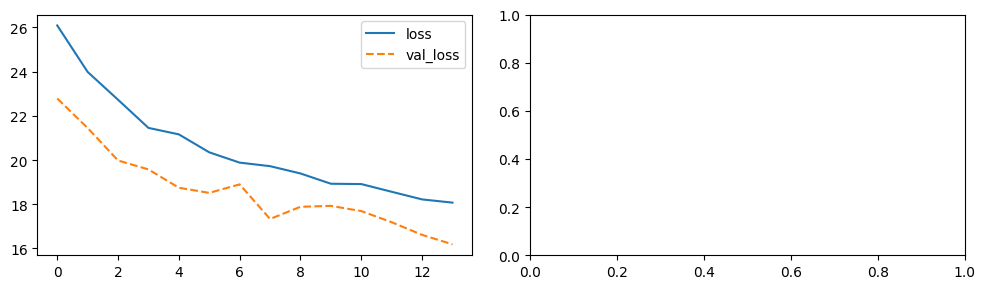

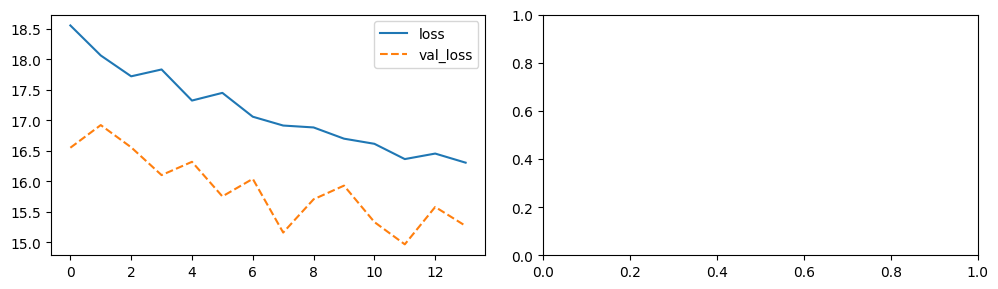

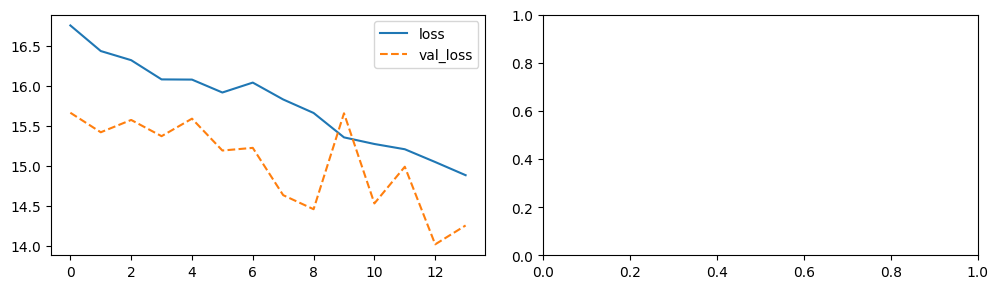

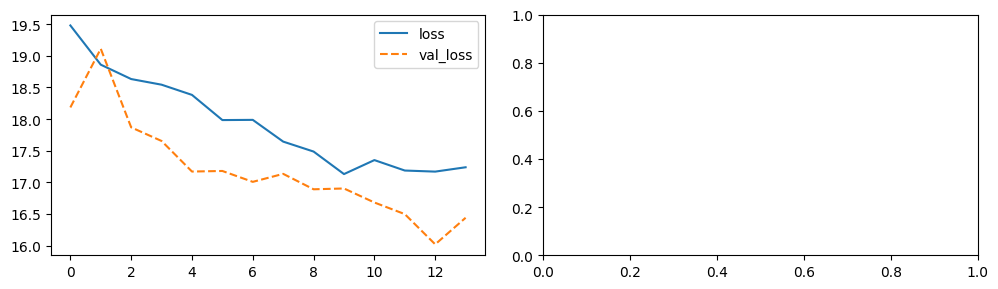

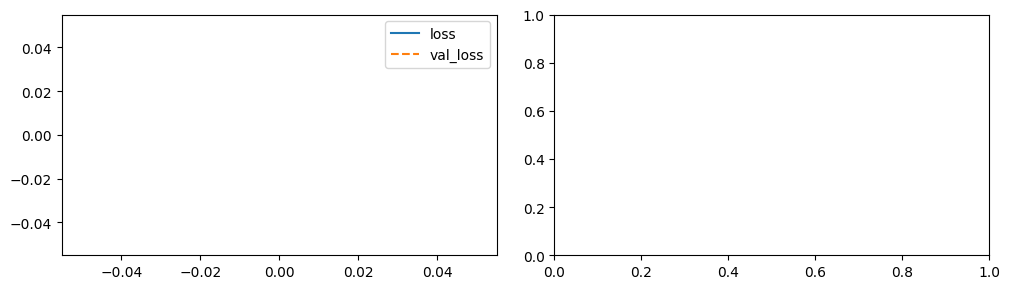

In [6]:
# TODO: play more with very large strides (e.g. 20), as it seems to lead to surprisingly good f2...
#[[6,0,True,20],[6,1,True,20],[6,2,True,20],[6,3,True,20],[2,0,True,2]]:
for strides, offset, keep_label, epochs in [[5,0,True,15],[5,1,True,15],[5,2,True,15],[7,0,True,15],[2,0,True,1]]:
    print(f"Strides: {strides} Offset: {offset} Keeping Label: {keep_label}")
    train_ew, val_ew = ds_gen_ew.get_datasets(2048,
                                          label_features=['EW_Node_Location_nb'],
                                          shuffle=True,
                                          only_ew_sk=False,
                                          stride=1 if keep_label else strides,
                                          keep_label_stride=1 if not keep_label else strides,
                                          stride_offset=offset,
                                          verbose=1)

    hist = model_ew.fit(train_ew,
                    val_ds=val_ew,
                    epochs=epochs,
                    early_stopping=0,
                    target_metric='val_mse',
                    save_best_only=False,
                    verbose=2,
                    plot_hist=True,
                    callbacks=[ClearMemoryCallback()])
    
    del train_ew
    del val_ew
    
    preds_df = localizer.create_prediction_df(ds_gen=ds_gen_ew,
                                model=model_ew,
                                train=False,
                                test=False,
                                stateful=False,
                                output_dirs=['EW'],
                                object_limit=None,
                                only_ew_sk=False,
                                ds_batch_size=1024,
                                prediction_batches=4,
                                verbose=2)
    
    subm_df = localizer.postprocess_predictions(preds_df=preds_df,
                                                dirs=['EW'],
                                                threshold=60.0,
                                                add_initial_node=True,
                                                clean_consecutives=True,
                                                deepcopy=False)

    evaluator, sub_df = localizer.evaluate_localizer(subm_df=subm_df,
                                                    gt_path=challenge_data_dir / 'train_labels.csv',
                                                    object_ids=list(map(int, ds_gen_ew.val_keys)),
                                                    dirs=['EW'],
                                                    with_initial_node=False,
                                                    return_scores=False,
                                                    verbose=1)

    gc.collect()

print("Done. Performing final evaluation")
peak_nb_padding = 100
for threshold in np.linspace(peak_nb_padding*0.3, peak_nb_padding*0.80, 11):
    print("-------------------------------")
    print(f"Threshold {threshold:.2f}:")
    subm_df = localizer.postprocess_predictions(preds_df=preds_df,
                                                dirs=['EW'],
                                                threshold=threshold,
                                                add_initial_node=True,
                                                clean_consecutives=True,
                                                deepcopy=False)

    evaluator, sub_df = localizer.evaluate_localizer(subm_df=subm_df,
                                                    gt_path=challenge_data_dir / 'train_labels.csv',
                                                    object_ids=list(map(int, ds_gen_ew.val_keys))[:],
                                                    dirs=['EW'],
                                                    with_initial_node=False,
                                                    return_scores=False,
                                                    verbose=1)


In [ ]:
train_ns, val_ns = ds_gen_ns.get_stateful_datasets(
                                          with_identifier=True,
                                          label_features=['NS_Node_Location_nb'],
                                          stride=1)
labels = np.stack([element for element in val_ns.map(lambda x,y,z:x).as_numpy_iterator()])
print(labels.shape)

In [ ]:
print(labels[:10,3,:])

In [ ]:
train_ns, val_ns = ds_gen_ns.get_stateful_datasets(
                                          label_features=['NS_Node_Location_nb'],
                                          stride=1)
print(train_ns.element_spec)

model_ns = prediction_models.STATEFUL_LSTM(train_ns, val_ns,
                                            dense_layers=[32,16],
                                            lstm_layers=[48,48],
                                            l2_reg=0.000,
                                            mixed_dropout_dense=0.25,
                                            mixed_dropout_lstm=0.25,
                                            lr_scheduler=[0.003,7500,0.9],
                                            seed=0)

model_ns.summary()

In [ ]:

hist = model_ns.fit(train_ns, val_ds=val_ns,
                    epochs=2,
                    eval_frequency=2,
                    verbose=1,
                    plot_hist=False)

In [10]:
model_ew.model.save('submission/models/EW_localizer_cnn.hdf5')
pickle.dump(ds_gen_ew.scaler, open('submission/models/EW_localizer_scaler_cnn.pkl', 'wb'))

/home/david/miniconda3/envs/splid-gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
# del train_ns
# del val_ns
gc.collect()

9450

### NS

In [5]:
train_ns, val_ns = ds_gen_ns.get_datasets(2048,
                                          label_features=['EW_Node_Location_nb', 'NS_Node_Location_nb'],
                                          shuffle=True,
                                          only_ew_sk=False,
                                          stride=1,
                                          keep_label_stride=10,
                                          verbose=1)
print(train_ns.element_spec) # 673786

  0%|          | 0/1520 [00:00<?, ?it/s]

100%|██████████| 1520/1520 [00:13<00:00, 111.90it/s]
2024-02-27 17:46:32.368448: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 17:46:32.393774: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 17:46:32.393847: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 17:46:32.396177: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 17:4

Train-DS Cardinality: tf.Tensor(340752, shape=(), dtype=int64)
Val-DS Cardinality: tf.Tensor(85309, shape=(), dtype=int64)
(TensorSpec(shape=(None, 128, 11), dtype=tf.float32, name=None), {'EW_Node_Location_nb': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'NS_Node_Location_nb': TensorSpec(shape=(None,), dtype=tf.float32, name=None)})


In [6]:
utils.set_random_seed(42)
model_ns = prediction_models.Dense_NN(val_ns, # TODO: calculate receptive fields
                                        conv1d_layers=[[64,7,1,1,1],[64,7,1,1,1],[48,7,2,1,1]], # TODO: try smaller kernels again
                                        dense_layers=[64,32],
                                        l2_reg=0.00025,
                                        mixed_batchnorm=True,
                                        mixed_dropout_dense=0.05,
                                        mixed_dropout_cnn=0.1,
                                        lr_scheduler=[0.005,7000,0.9],
                                        output_type='regression',
                                        final_activation='linear',
                                        asymmetric_loss=0.0, # value<0 to penalize underestimation more # TODO: test more values
                                        seed=0)

model_ns.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 128, 11)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 122, 64)              4992      ['Input[0][0]']               
                                                                                                  
 batch_normalization (Batch  (None, 122, 64)              256       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 122, 64)              0         ['batch_normalization[0][0

In [7]:
del train_ns
del val_ns
gc.collect()

503

Strides: 5 Offset: 3 Keeping Label: True


  0%|          | 7/1520 [00:00<00:22, 67.12it/s]

100%|██████████| 380/380 [00:05<00:00, 70.56it/s] 


Train-DS Cardinality: tf.Tensor(683146, shape=(), dtype=int64)
Val-DS Cardinality: tf.Tensor(170808, shape=(), dtype=int64)
Starting training. Optimizing "val_mse"
Epoch 1/10


2024-02-27 16:38:58.359612: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.70GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-27 16:38:58.412766: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.70GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


334/334 - 110s - loss: 13.4816 - EW_Node_Location_nb_loss: 4.3047 - NS_Node_Location_nb_loss: 5.1876 - EW_Node_Location_nb_mse: 4.3047 - NS_Node_Location_nb_mse: 5.1876 - val_loss: 15.1851 - val_EW_Node_Location_nb_loss: 5.2035 - val_NS_Node_Location_nb_loss: 5.9704 - val_EW_Node_Location_nb_mse: 5.2035 - val_NS_Node_Location_nb_mse: 5.9704 - 110s/epoch - 329ms/step
Epoch 2/10
334/334 - 106s - loss: 13.2121 - EW_Node_Location_nb_loss: 4.2873 - NS_Node_Location_nb_loss: 4.9027 - EW_Node_Location_nb_mse: 4.2873 - NS_Node_Location_nb_mse: 4.9027 - val_loss: 14.7177 - val_EW_Node_Location_nb_loss: 4.9514 - val_NS_Node_Location_nb_loss: 5.7300 - val_EW_Node_Location_nb_mse: 4.9514 - val_NS_Node_Location_nb_mse: 5.7300 - 106s/epoch - 317ms/step
Epoch 3/10
334/334 - 103s - loss: 12.8925 - EW_Node_Location_nb_loss: 4.0674 - NS_Node_Location_nb_loss: 4.7835 - EW_Node_Location_nb_mse: 4.0674 - NS_Node_Location_nb_mse: 4.7835 - val_loss: 14.1036 - val_EW_Node_Location_nb_loss: 5.0249 - val_NS_Nod

/home/david/Code/splid-challenge/base/prediction_models.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Threshold: 30.0	 Precision: 0.76 Recall: 0.95 F2: 0.903 RMSE: 1.20 | TP: 671 FP: 211 FN: 37 (ID: 9|363 IK: 400|31 AD: 271|6)
Threshold: 34.0	 Precision: 0.78 Recall: 0.94 F2: 0.905 RMSE: 1.02 | TP: 667 FP: 187 FN: 41 (ID: 6|366 IK: 395|36 AD: 272|5)
Threshold: 38.0	 Precision: 0.80 Recall: 0.95 F2: 0.914 RMSE: 1.00 | TP: 670 FP: 165 FN: 38 (ID: 6|366 IK: 399|32 AD: 271|6)
Threshold: 42.0	 Precision: 0.83 Recall: 0.94 F2: 0.919 RMSE: 0.95 | TP: 669 FP: 139 FN: 39 (ID: 5|367 IK: 398|33 AD: 271|6)
Threshold: 46.0	 Precision: 0.85 Recall: 0.94 F2: 0.921 RMSE: 0.93 | TP: 666 FP: 119 FN: 42 (ID: 3|369 IK: 395|36 AD: 271|6)
Threshold: 50.0	 Precision: 0.87 Recall: 0.94 F2: 0.928 RMSE: 0.87 | TP: 669 FP: 102 FN: 39 (ID: 3|369 IK: 399|32 AD: 270|7)
Threshold: 54.0	 Precision: 0.89 Recall: 0.94 F2: 0.931 RMSE: 0.75 | TP: 667 FP: 85 FN: 41 (ID: 3|369 IK: 398|33 AD: 269|8)
Threshold: 58.0	 Precision: 0.90 Recall: 0.94 F2: 0.931 RMSE: 0.71 | TP: 665 FP: 75 FN: 43 (ID: 3|369 IK: 396|35 AD: 269|8)
Th

100%|██████████| 380/380 [00:02<00:00, 137.03it/s]


Train-DS Cardinality: tf.Tensor(683148, shape=(), dtype=int64)
Val-DS Cardinality: tf.Tensor(170797, shape=(), dtype=int64)
Starting training. Optimizing "val_mse"
Epoch 1/10
334/334 - 101s - loss: 13.2016 - EW_Node_Location_nb_loss: 4.2081 - NS_Node_Location_nb_loss: 5.0233 - EW_Node_Location_nb_mse: 4.2081 - NS_Node_Location_nb_mse: 5.0233 - val_loss: 13.8886 - val_EW_Node_Location_nb_loss: 4.7159 - val_NS_Node_Location_nb_loss: 5.1890 - val_EW_Node_Location_nb_mse: 4.7159 - val_NS_Node_Location_nb_mse: 5.1890 - 101s/epoch - 302ms/step
Epoch 2/10
334/334 - 99s - loss: 12.4877 - EW_Node_Location_nb_loss: 3.9432 - NS_Node_Location_nb_loss: 4.5660 - EW_Node_Location_nb_mse: 3.9432 - NS_Node_Location_nb_mse: 4.5660 - val_loss: 13.8278 - val_EW_Node_Location_nb_loss: 4.7656 - val_NS_Node_Location_nb_loss: 5.0855 - val_EW_Node_Location_nb_mse: 4.7656 - val_NS_Node_Location_nb_mse: 5.0855 - 99s/epoch - 297ms/step
Epoch 3/10
334/334 - 104s - loss: 12.0742 - EW_Node_Location_nb_loss: 3.9584 -

/home/david/Code/splid-challenge/base/prediction_models.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Threshold: 30.0	 Precision: 0.76 Recall: 0.95 F2: 0.905 RMSE: 1.09 | TP: 674 FP: 217 FN: 34 (ID: 2|370 IK: 402|29 AD: 272|5)
Threshold: 34.0	 Precision: 0.79 Recall: 0.95 F2: 0.913 RMSE: 1.01 | TP: 673 FP: 182 FN: 35 (ID: 2|370 IK: 401|30 AD: 272|5)
Threshold: 38.0	 Precision: 0.81 Recall: 0.95 F2: 0.917 RMSE: 0.93 | TP: 672 FP: 162 FN: 36 (ID: 2|370 IK: 401|30 AD: 271|6)
Threshold: 42.0	 Precision: 0.83 Recall: 0.95 F2: 0.920 RMSE: 0.84 | TP: 671 FP: 142 FN: 37 (ID: 0|372 IK: 400|31 AD: 271|6)
Threshold: 46.0	 Precision: 0.84 Recall: 0.94 F2: 0.921 RMSE: 0.81 | TP: 669 FP: 129 FN: 39 (ID: 0|372 IK: 399|32 AD: 270|7)
Threshold: 50.0	 Precision: 0.86 Recall: 0.95 F2: 0.928 RMSE: 0.75 | TP: 670 FP: 109 FN: 38 (ID: 0|372 IK: 400|31 AD: 270|7)
Threshold: 54.0	 Precision: 0.89 Recall: 0.95 F2: 0.934 RMSE: 0.65 | TP: 670 FP: 86 FN: 38 (ID: 0|372 IK: 400|31 AD: 270|7)
Threshold: 58.0	 Precision: 0.91 Recall: 0.94 F2: 0.937 RMSE: 0.59 | TP: 668 FP: 63 FN: 40 (ID: 0|372 IK: 400|31 AD: 268|9)
Th

100%|██████████| 380/380 [00:02<00:00, 139.07it/s]


Train-DS Cardinality: tf.Tensor(683218, shape=(), dtype=int64)
Val-DS Cardinality: tf.Tensor(170841, shape=(), dtype=int64)
Starting training. Optimizing "val_mse"
Epoch 1/10
334/334 - 98s - loss: 12.4083 - EW_Node_Location_nb_loss: 3.9827 - NS_Node_Location_nb_loss: 4.4800 - EW_Node_Location_nb_mse: 3.9827 - NS_Node_Location_nb_mse: 4.4800 - val_loss: 14.3583 - val_EW_Node_Location_nb_loss: 5.3649 - val_NS_Node_Location_nb_loss: 5.0397 - val_EW_Node_Location_nb_mse: 5.3649 - val_NS_Node_Location_nb_mse: 5.0397 - 98s/epoch - 293ms/step
Epoch 2/10
334/334 - 99s - loss: 12.1446 - EW_Node_Location_nb_loss: 3.7261 - NS_Node_Location_nb_loss: 4.4567 - EW_Node_Location_nb_mse: 3.7261 - NS_Node_Location_nb_mse: 4.4567 - val_loss: 14.0899 - val_EW_Node_Location_nb_loss: 4.6260 - val_NS_Node_Location_nb_loss: 5.5010 - val_EW_Node_Location_nb_mse: 4.6260 - val_NS_Node_Location_nb_mse: 5.5010 - 99s/epoch - 297ms/step
Epoch 3/10
334/334 - 97s - loss: 11.8837 - EW_Node_Location_nb_loss: 3.7782 - NS

/home/david/Code/splid-challenge/base/prediction_models.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Threshold: 30.0	 Precision: 0.82 Recall: 0.95 F2: 0.918 RMSE: 1.01 | TP: 670 FP: 147 FN: 38 (ID: 3|369 IK: 397|34 AD: 273|4)
Threshold: 34.0	 Precision: 0.84 Recall: 0.94 F2: 0.923 RMSE: 0.83 | TP: 669 FP: 125 FN: 39 (ID: 3|369 IK: 398|33 AD: 271|6)
Threshold: 38.0	 Precision: 0.86 Recall: 0.94 F2: 0.925 RMSE: 0.75 | TP: 668 FP: 112 FN: 40 (ID: 1|371 IK: 397|34 AD: 271|6)
Threshold: 42.0	 Precision: 0.87 Recall: 0.94 F2: 0.927 RMSE: 0.74 | TP: 667 FP: 99 FN: 41 (ID: 1|371 IK: 396|35 AD: 271|6)
Threshold: 46.0	 Precision: 0.88 Recall: 0.94 F2: 0.930 RMSE: 0.84 | TP: 667 FP: 87 FN: 41 (ID: 1|371 IK: 397|34 AD: 270|7)
Threshold: 50.0	 Precision: 0.91 Recall: 0.94 F2: 0.936 RMSE: 0.66 | TP: 667 FP: 65 FN: 41 (ID: 0|372 IK: 397|34 AD: 270|7)
Threshold: 54.0	 Precision: 0.93 Recall: 0.94 F2: 0.941 RMSE: 0.56 | TP: 668 FP: 50 FN: 40 (ID: 0|372 IK: 398|33 AD: 270|7)
Threshold: 58.0	 Precision: 0.95 Recall: 0.94 F2: 0.945 RMSE: 0.48 | TP: 668 FP: 34 FN: 40 (ID: 0|372 IK: 398|33 AD: 270|7)
Thres

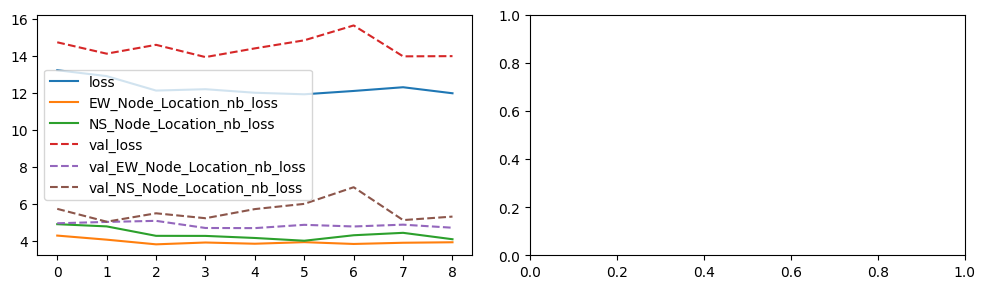

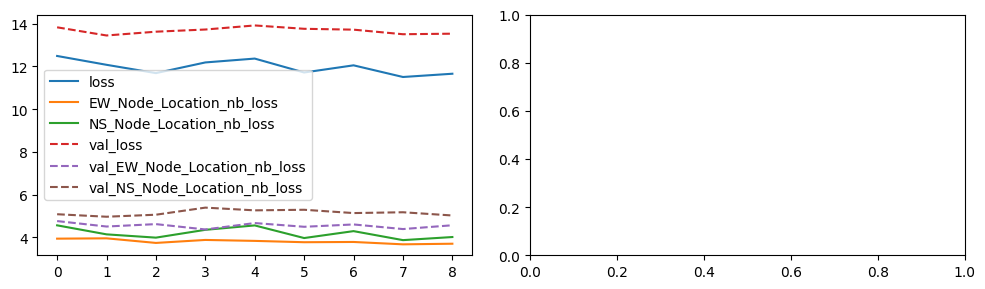

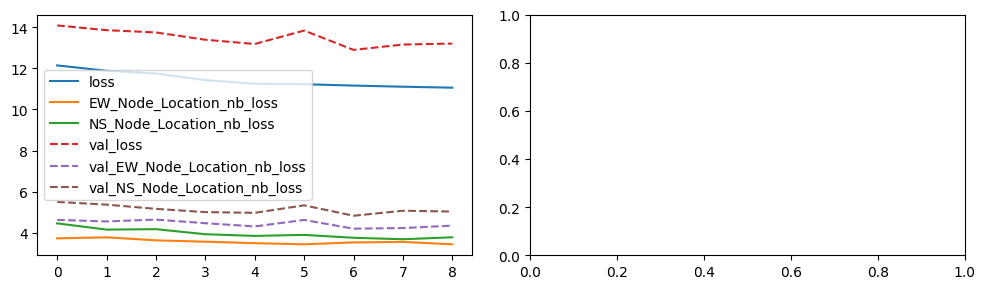

In [10]:
#[[5,0,True,20],[5,1,True,20],[5,2,True,20],[5,3,True,20],[5,4,True,20]]:
for strides, offset, keep_label, epochs in [[5,0,True,20],[5,1,True,20],[5,2,True,20],[5,3,True,20]]:#,[6,0,True,20],[5,1,True,20],[2,1,True,1]]:
    print(f"Strides: {strides} Offset: {offset} Keeping Label: {keep_label}")
    train_ns, val_ns = ds_gen_ns.get_datasets(2048,
                                          label_features=['EW_Node_Location_nb', 'NS_Node_Location_nb'],
                                          shuffle=True,
                                          only_ew_sk=False,
                                          stride=1 if keep_label else strides,
                                          keep_label_stride=1 if not keep_label else strides,
                                          stride_offset=offset,
                                          verbose=1)

    hist = model_ns.fit(train_ns,
                        val_ds=val_ns,
                        epochs=epochs,
                        verbose=2,
                        plot_hist=True,
                        early_stopping=0,
                        target_metric='val_mse',
                        save_best_only=False,
                        callbacks=[ClearMemoryCallback()])
    
    del train_ns
    del val_ns
    
    print("====================Evaluating======================")
    scores = localizer.perform_evaluation_pipeline(ds_gen_ns,
                                      model_ns,
                                      'val',
                                      gt_path = challenge_data_dir / 'train_labels.csv',
                                      output_dirs=['EW', 'NS'],
                                      prediction_batches=5,
                                      thresholds = np.linspace(30.0, 70.0, 11),
                                      object_limit=None,
                                      with_initial_node=False,
                                      nodes_to_consider=['ID'],
                                      verbose=0)
    print("====================================================")

    gc.collect()

print("Done.")
# NS+EW ID+AD (10s-30e): 0.852 | TP: 562 FP: 142 FN: 87
# TODO: training on IK leads to lots of AD detections?`
# TODO: Probably, IK and ID are detected based on the signature of the corresponding SK maneuver - thats why smaller horizons and inputstrides may help
# TODO: but how to use this information?
# TODO: IK+AD also detects some ID...
# TODO: AD seems to be easiest by far, probably clear local signature
# TODO: train proper IK-ID model, with smaller training stride, maybe slightly larger horizons and input stride 2.

In [16]:
scores = localizer.perform_evaluation_pipeline(ds_gen_ns,
                                      model_ns,
                                      'val',
                                      gt_path = challenge_data_dir / 'train_labels.csv',
                                      output_dirs=['NS'],
                                      prediction_batches=5,
                                      thresholds = np.linspace(5.0, 70.0, 16),
                                      object_limit=None,
                                      with_initial_node=False,
                                      nodes_to_consider=['IK'],
                                      verbose=0)

Threshold: 5.0	 Precision: 0.05 Recall: 0.49 F2: 0.181 RMSE: 1.85 | TP: 0 FP: 0 FN: 213
Threshold: 9.3	 Precision: 0.06 Recall: 0.49 F2: 0.213 RMSE: 1.76 | TP: 0 FP: 0 FN: 213
Threshold: 13.7	 Precision: 0.08 Recall: 0.49 F2: 0.239 RMSE: 1.54 | TP: 0 FP: 0 FN: 213
Threshold: 18.0	 Precision: 0.10 Recall: 0.48 F2: 0.273 RMSE: 1.38 | TP: 0 FP: 0 FN: 213
Threshold: 22.3	 Precision: 0.13 Recall: 0.48 F2: 0.313 RMSE: 1.36 | TP: 0 FP: 0 FN: 213
Threshold: 26.7	 Precision: 0.16 Recall: 0.48 F2: 0.342 RMSE: 1.48 | TP: 0 FP: 0 FN: 213
Threshold: 31.0	 Precision: 0.21 Recall: 0.47 F2: 0.372 RMSE: 1.02 | TP: 0 FP: 0 FN: 213
Threshold: 35.3	 Precision: 0.27 Recall: 0.46 F2: 0.406 RMSE: 1.17 | TP: 0 FP: 0 FN: 213
Threshold: 39.7	 Precision: 0.36 Recall: 0.45 F2: 0.428 RMSE: 1.10 | TP: 0 FP: 0 FN: 213
Threshold: 44.0	 Precision: 0.43 Recall: 0.44 F2: 0.439 RMSE: 0.97 | TP: 0 FP: 0 FN: 213
Threshold: 48.3	 Precision: 0.54 Recall: 0.44 F2: 0.453 RMSE: 0.92 | TP: 0 FP: 0 FN: 213
Threshold: 52.7	 Precis

In [12]:
scores = localizer.perform_evaluation_pipeline(ds_gen_ns,
                                      model_ns,
                                      'val',
                                      gt_path = challenge_data_dir / 'train_labels.csv',
                                      output_dirs=['NS'],
                                      prediction_batches=5,
                                      thresholds = np.linspace(30.0, 70.0, 11),
                                      object_limit=None,
                                      with_initial_node=False,
                                      verbose=0)

Threshold: 30.0	 Precision: 0.14 Recall: 0.77 F2: 0.41 RMSE: 2.24 TP: 329 FP: 1967 FN: 100
Threshold: 34.0	 Precision: 0.17 Recall: 0.77 F2: 0.45 RMSE: 2.11 TP: 330 FP: 1651 FN: 99
Threshold: 38.0	 Precision: 0.18 Recall: 0.76 F2: 0.47 RMSE: 1.92 TP: 325 FP: 1445 FN: 104
Threshold: 42.0	 Precision: 0.20 Recall: 0.74 F2: 0.48 RMSE: 2.27 TP: 319 FP: 1271 FN: 110
Threshold: 46.0	 Precision: 0.23 Recall: 0.71 F2: 0.50 RMSE: 2.22 TP: 303 FP: 1028 FN: 126
Threshold: 50.0	 Precision: 0.26 Recall: 0.65 F2: 0.50 RMSE: 1.97 TP: 277 FP: 790 FN: 152
Threshold: 54.0	 Precision: 0.31 Recall: 0.61 F2: 0.51 RMSE: 1.81 TP: 262 FP: 593 FN: 167
Threshold: 58.0	 Precision: 0.35 Recall: 0.57 F2: 0.51 RMSE: 1.84 TP: 246 FP: 459 FN: 183
Threshold: 62.0	 Precision: 0.37 Recall: 0.51 F2: 0.48 RMSE: 1.57 TP: 220 FP: 367 FN: 209
Threshold: 66.0	 Precision: 0.41 Recall: 0.45 F2: 0.44 RMSE: 1.57 TP: 191 FP: 271 FN: 238
Threshold: 70.0	 Precision: 0.44 Recall: 0.38 F2: 0.39 RMSE: 1.35 TP: 165 FP: 210 FN: 264


In [ ]:
train_ns, val_ns = ds_gen_ns.get_datasets(512, label_features=['NS_Node_Location_nb'], shuffle=True, stride=1)
model_ns = prediction_models.Dense_NN_regression(val_ns, conv1d_layers=[[32,6],[32,6]], dense_layers=[16,4],
                                                 l2_reg=0.0, mixed_dropout=0.2,
                                                 lr_scheduler=[0.002,15000,0.9],
                                                 final_activation='relu',
                                                 seed=0)
model_ns.load_model('submission/models/ns_localizer_cnn.hdf5')
model_ns.summary()
hist = model_ns.fit(train_ns, val_ds=val_ns, epochs=10, verbose=1, plot_hist=True, callbacks=[])

In [33]:
del train_ns
del val_ns
gc.collect()

0

In [34]:
train_ns, val_ns = ds_gen_ns.get_datasets(2048,
                                          label_features=['NS_Node_Location_nb'],
                                          shuffle=True,
                                          only_ew_sk=False,
                                          stride=6,
                                          keep_label_stride=1, #!
                                          stride_offset=1,
                                          verbose=2)
print(train_ns.element_spec)

  0%|          | 0/1520 [00:00<?, ?it/s]

100%|██████████| 380/380 [00:04<00:00, 86.03it/s]


Train-DS Cardinality: tf.Tensor(550502, shape=(), dtype=int64)
Val-DS Cardinality: tf.Tensor(137608, shape=(), dtype=int64)
(TensorSpec(shape=(None, 128, 16), dtype=tf.float32, name=None), {'NS_Node_Location_nb': TensorSpec(shape=(None,), dtype=tf.float32, name=None)})


Starting training. Optimizing "val_mse"
Epoch 1/10
269/269 - 19s - loss: 6.7906 - mse: 4.2205 - mae: 0.1526 - val_loss: 6.2250 - val_mse: 3.6672 - val_mae: 0.1021 - 19s/epoch - 70ms/step
Epoch 2/10
269/269 - 17s - loss: 6.4583 - mse: 3.9122 - mae: 0.1367 - val_loss: 6.3386 - val_mse: 3.8006 - val_mae: 0.1030 - 17s/epoch - 63ms/step
Epoch 3/10
269/269 - 16s - loss: 6.4004 - mse: 3.8747 - mae: 0.1375 - val_loss: 6.3571 - val_mse: 3.8451 - val_mae: 0.1108 - 16s/epoch - 60ms/step
Epoch 4/10
269/269 - 17s - loss: 6.1636 - mse: 3.6642 - mae: 0.1351 - val_loss: 5.9343 - val_mse: 3.4485 - val_mae: 0.1026 - 17s/epoch - 63ms/step
Epoch 5/10
269/269 - 17s - loss: 5.7281 - mse: 3.2570 - mae: 0.1258 - val_loss: 5.9836 - val_mse: 3.5250 - val_mae: 0.0946 - 17s/epoch - 62ms/step
Epoch 6/10
269/269 - 16s - loss: 5.9172 - mse: 3.4712 - mae: 0.1269 - val_loss: 5.8597 - val_mse: 3.4259 - val_mae: 0.0950 - 16s/epoch - 60ms/step
Epoch 7/10
269/269 - 16s - loss: 5.9023 - mse: 3.4821 - mae: 0.1282 - val_loss

/home/david/Code/splid-challenge/base/prediction_models.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


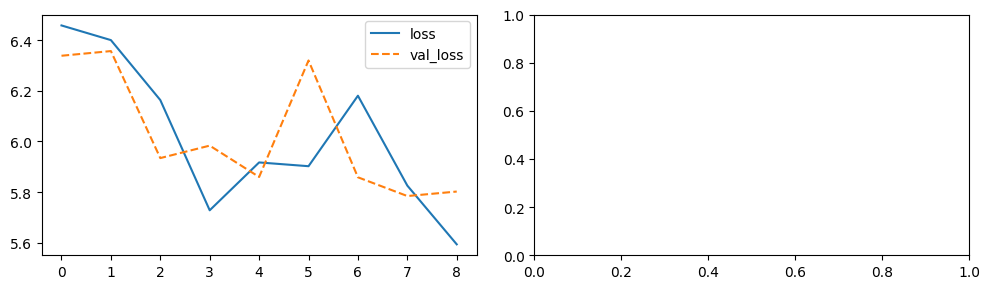

In [35]:
hist = model_ns.fit(train_ns,
                    val_ds=val_ns,
                    epochs=10,
                    verbose=2,
                    plot_hist=True,
                    early_stopping=20,
                    target_metric='val_mse',
                    save_best_only=False,
                    callbacks=[ClearMemoryCallback()])

Starting training. Optimizing "val_loss"
Epoch 1/50


641/641 [==============================] - ETA: 0s - loss: 3.4016 - mse: 2.7507 - mae: 0.1570
Epoch 1: val_loss improved from inf to 6.76846, saving model to best_model.hdf5
641/641 [==============================] - 18s 26ms/step - loss: 3.4016 - mse: 2.7507 - mae: 0.1570 - val_loss: 6.7685 - val_mse: 6.1177 - val_mae: 0.2297
Epoch 2/50
639/641 [============================>.] - ETA: 0s - loss: 3.3910 - mse: 2.7405 - mae: 0.1545
Epoch 2: val_loss improved from 6.76846 to 6.73232, saving model to best_model.hdf5
641/641 [==============================] - 18s 25ms/step - loss: 3.3953 - mse: 2.7448 - mae: 0.1546 - val_loss: 6.7323 - val_mse: 6.0820 - val_mae: 0.2629
Epoch 3/50
640/641 [============================>.] - ETA: 0s - loss: 3.3926 - mse: 2.7425 - mae: 0.1569
Epoch 3: val_loss did not improve from 6.73232
641/641 [==============================] - 17s 25ms/step - loss: 3.3907 - mse: 2.7406 - mae: 0.1568 - val_loss: 6.8026 - val_mse: 6.1527 - val_mae: 0.2177
Epoch 4/50
640/641 [

/home/david/Code/splid-challenge/base/prediction_models.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


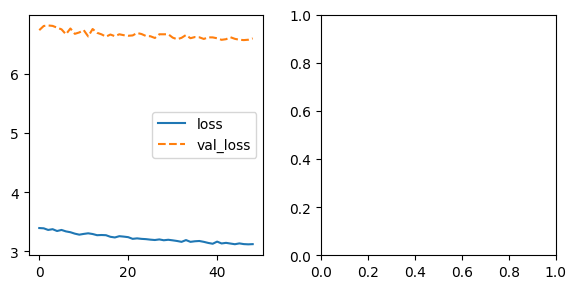

In [28]:
hist = model_ew.fit(train_ew,
                    val_ds=val_ew,
                    epochs=50,
                    verbose=1,
                    plot_hist=True,
                    early_stopping=15,
                    target_metric='val_loss',
                    save_best_only=True,
                    callbacks=[])

In [11]:
model_ns.model.save('submission/models/ADIK_localizer_cnn.hdf5')
pickle.dump(ds_gen_ns.scaler, open('submission/models/ADIK_localizer_scaler_cnn.pkl', 'wb'))

/home/david/miniconda3/envs/splid-gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_ns.save_weights('submission/models/ns_localizer_lstm.hdf5')

In [ ]:
print(model_ns.model.optimizer.learning_rate)

In [ ]:
train_ns, val_ns = ds_gen_ns.get_datasets(512, label_features=['NS_Node_Location'], shuffle=True, stride=1)

model_ns = prediction_models.Dense_NN(train_ns, conv1d_layers=[], dense_layers=[256, 128,64,32], l2_reg=0.0, mixed_dropout=0.0, lr_scheduler=[], seed=0)
train_ns = train_ns.map(lambda x,y:(x,y['NS_Node_Location']))
val_ns = val_ns.map(lambda x,y:(x,y['NS_Node_Location'])) # temporary fix to allow class weights

model_ns.summary()
hist = model_ns.fit(train_ns, val_ds=val_ns, epochs=20, verbose=1, plot_hist=False, class_weight={0: 0.5, 1: 20.0}, callbacks=[])
model_ns.model.save('models/ns_localizer.hdf5')

model_ns.plot_hist(hist, [k for k in hist.history.keys() if 'loss' in k])
model_ns.plot_hist(hist, [k for k in hist.history.keys() if 'accuracy' in k])

In [2]:
model_ns = tf.keras.models.load_model("/home/david/Code/splid-challenge/wandb/run-20240227_144053-ab0y3a44/files\model_ab0y3a44.hdf5", compile=False )


2024-02-27 15:46:14.075854: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 15:46:14.102142: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 15:46:14.102210: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 15:46:14.104280: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 15:46:14.104350: I external/local_xla/xla/stream_executor

In [6]:
model_ns = tf.keras.models.load_model("submission/models/NS_localizer_cnn.hdf5")

2024-02-26 22:45:13.562593: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-26 22:45:13.589697: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-26 22:45:13.589801: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-26 22:45:13.591440: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-26 22:45:13.591518: I external/local_xla/xla/stream_executor

In [17]:
object_limit = None
directions = ['NS']

preds_df = localizer.create_prediction_df(ds_gen=ds_gen_ns,
                                model=model_ns,
                                train=False,
                                test=False,
                                stateful=False,
                                output_dirs=directions,
                                object_limit=object_limit,
                                only_ew_sk=False,
                                ds_batch_size=1024,
                                prediction_batches=5,
                                verbose=1)

162/162 [==============================] - 3s 16ms/step


In [23]:
peak_nb_padding=100
for threshold in np.linspace(peak_nb_padding*0.3, peak_nb_padding*0.8, 11):
    print("-------------------------------")
    print(f"Threshold {threshold:.2f}:")
    subm_df = localizer.postprocess_predictions(preds_df=preds_df,
                                                dirs=directions,
                                                threshold=threshold,
                                                add_initial_node=True,
                                                clean_consecutives=True,
                                                deepcopy=False)

    evaluator, sub_df = localizer.evaluate_localizer(subm_df=subm_df,
                                                    gt_path=challenge_data_dir / 'train_labels.csv',
                                                    object_ids=list(map(int, ds_gen_ns.val_keys))[:object_limit],
                                                    dirs=directions,
                                                    with_initial_node=False,
                                                    nodes_to_consider=['ID'],
                                                    return_scores=False,
                                                    verbose=1)

# EW after 180 epochs:
# 50: TP: 617 FP: 66 FN: 34
# 55: TP: 614 FP: 46 FN: 37
# 60: TP: 613 FP: 37 FN: 38
# 65: TP: 608 FP: 24 FN: 43
# 70: TP: 606 FP: 20 FN: 45

# NS after 60 epochs:
# 50: TP: 385 FP: 117 FN: 49
# 55: TP: 380 FP: 92 FN: 49
# 60: TP: 380 FP: 61 FN: 49
# 65: TP: 380 FP: 43 FN: 49
# 70: TP: 376 FP: 30 FN: 53


# Combined after 100 epochs
# 50: TP: 923 FP: 364 FN: 157
# 55: TP: 917 FP: 281 FN: 163
# 60: TP: 911 FP: 196 FN: 169
# 65: TP: 902 FP: 135 FN: 178
# 70: TP: 894 FP: 100 FN: 186


-------------------------------
Threshold 30.00:
Evaluator ignoring classifications
Precision: 0.19
Recall: 0.93
F2: 0.527
RMSE: 1.081
TP: 201 FP: 842 FN: 15
TP/FN based on Node:
ID: 201|15
IK: 0|213
AD: 0|0
-------------------------------
Threshold 35.00:
Evaluator ignoring classifications
Precision: 0.27
Recall: 0.92
F2: 0.618
RMSE: 1.172
TP: 198 FP: 541 FN: 18
TP/FN based on Node:
ID: 198|18
IK: 0|213
AD: 0|0
-------------------------------
Threshold 40.00:
Evaluator ignoring classifications
Precision: 0.36
Recall: 0.88
F2: 0.685
RMSE: 1.049
TP: 191 FP: 339 FN: 25
TP/FN based on Node:
ID: 191|25
IK: 0|213
AD: 0|0
-------------------------------
Threshold 45.00:
Evaluator ignoring classifications
Precision: 0.46
Recall: 0.88
F2: 0.741
RMSE: 0.9027
TP: 189 FP: 222 FN: 27
TP/FN based on Node:
ID: 189|27
IK: 0|213
AD: 0|0
-------------------------------
Threshold 50.00:
Evaluator ignoring classifications
Precision: 0.58
Recall: 0.86
F2: 0.785
RMSE: 0.8296
TP: 186 FP: 135 FN: 30
TP/FN ba

KeyboardInterrupt: 

In [20]:
#precision, recall, f2, rmse, total_tp, total_fp, total_fn, total_df = evaluator.score()
for node in ['ID', 'AD', 'IK']:
    tp = len(total_df.loc[(total_df['Node'] == node) & (total_df['classification'] == 'TP')])
    #fp = len(total_df.loc[(total_df['Node'] == node) & (total_df['classification'] == 'FP')])
    fn = len(total_df.loc[(total_df['Node'] == node) & (total_df['classification'] == 'FN')])
    print(f"{node}: TP: {tp} FN: {fn}")

#EW:
# ID: TP: 114 FN: 42
# AD: TP: 264 FN: 13
# IK: TP: 203 FN: 15

#NS:  
# ID: TP: 112 FN: 104
# AD: TP: 0 FN: 0
# IK: TP: 185 FN: 28


ID: TP: 121 FN: 35
AD: TP: 267 FN: 10
IK: TP: 208 FN: 10


425/425 - 3s - 3s/epoch - 6ms/step
(202,)


/home/david/Code/splid-challenge/base/localizer.py:136: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[timeindex-20:timeindex+20, 'keep'] = True
/home/david/Code/splid-challenge/base/localizer.py:146: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


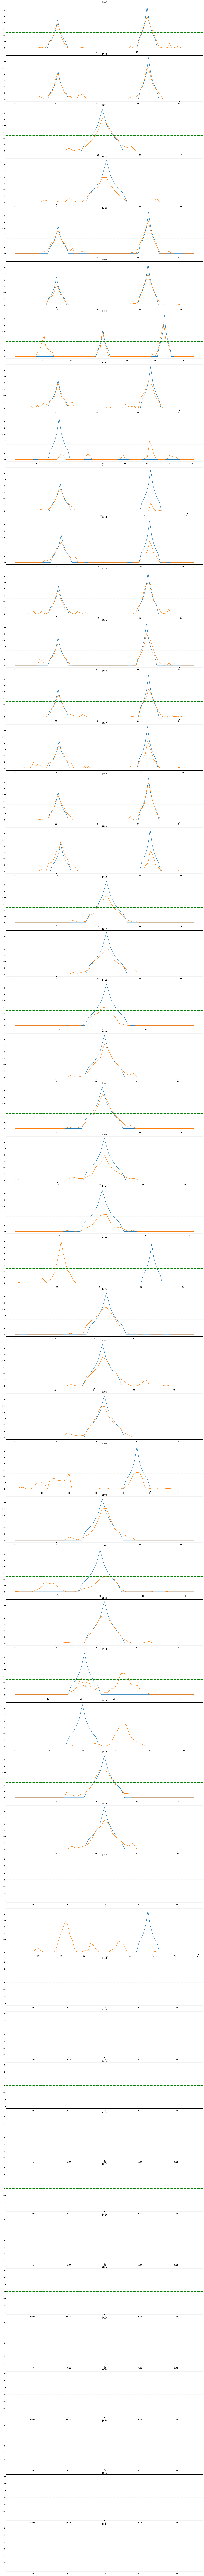

In [11]:
localizer.plot_prediction_curve(ds_gen=ds_gen_ns,
                                model=model_ns,
                                label_features=['NS_Node_Location_nb'],
                                object_ids=ds_gen_ns.val_keys[100:150],#['683','369','1433'],#ds_gen_ns.val_keys[100:150],
                                threshold=60.0,
                                zoom=True)